# 중고차 가격 예측 (Pycaret Only)

In [ ]:
!pip install pycaret==2.1.2

In [ ]:
!pip install scikit-learn==0.23 # 반드시 Scikit-learn 버전을 맞춰줘야 합니다!

In [ ]:
!pip install scipy==1.5.3 # 반드시 Scipy 버전을 맞춰줘야 합니다! 

In [5]:
# Googledrive Mount

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 일부 데이터(50%) 대상 Pycaret ( Catboost, RandomForest, ExtraTree )

In [13]:
# !pip install pycaret==2.1.2

from pycaret.regression import *

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import ExtraTreeRegressor

from catboost import CatBoostRegressor

import os

In [7]:
# csv file integration

used_car = pd.DataFrame()

for dirname, _, filenames in os.walk('/content/drive/MyDrive/used_car'):
    for filename in filenames:
            each_car = pd.read_csv(os.path.join(dirname, filename), encoding='utf-8')
            each_car['company'] = filename.split('.')[0]
            used_car = pd.concat([used_car,each_car], axis=0)

In [8]:
# Data sampling 50%, RandomForest, ExtraTree 튜닝 시 시간이 오래걸림

used_car  = used_car.sample(frac=0.5, random_state=1004)

In [9]:
used_car.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32066 entries, 5699 to 9159
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   model         32066 non-null  object 
 1   year          32066 non-null  int64  
 2   price         32066 non-null  int64  
 3   transmission  32066 non-null  object 
 4   mileage       32066 non-null  int64  
 5   fuelType      32066 non-null  object 
 6   tax           32066 non-null  int64  
 7   mpg           32066 non-null  float64
 8   engineSize    32066 non-null  float64
 9   company       32066 non-null  object 
dtypes: float64(2), int64(4), object(4)
memory usage: 2.7+ MB


In [ ]:
# DataFrame의 결측치, 이상치 제거 및 대체

used_car['model'] = used_car[['model']].apply(lambda x: x.str.strip())
used_car['engineSize'] = used_car[['engineSize']].replace(0,used_car['engineSize'].mode()[0])
used_car['tax'] = used_car[['tax']].replace(0,used_car[['tax']].median())


bmw.loc[(bmw['model']=='i3'), ['engineSize']] = 0.6 #engineSize 0인건 i3모델뿐이어서 실제값인 0.6으로 변경
# 삭제 bmw['engineSize'] = bmw[['engineSize']].replace(0,bmw['engineSize'].mode()[0])
bmw['tax'] = bmw['tax'].replace(to_replace=0, value=bmw['tax'].median())

In [ ]:
# 모델 분석환경 설정, 결측치는 Pycaret에서 자동처리 ( default : Numeric - mean, Categorical - constant )

model = setup(data=used_car, 
              target='price', 
              train_size=0.7,
              session_id=123,
              categorical_features = ['year'] # year 열은 연식으로 Categorical_feature로 강제 반영
              )

 
Setup Succesfully Completed.


,Description,Value
0,session_id,123
1,Transform Target,False
2,Transform Target Method,None
3,Original Data,"(32066, 10)"
4,Missing Values,False
5,Numeric Features,4
6,Categorical Features,5
7,Ordinal Features,False
8,High Cardinality Features,False
9,High Cardinality Method,None


In [ ]:
# Model Compare (Hyper-parameter defalut)

top_3_models = compare_models(sort='RMSE', n_select=3)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
0,CatBoost Regressor,1623.0125,8162171.9176,2796.4960,0.9353,0.1411,0.0964,1.4353
1,Random Forest,1763.8195,10031924.5309,3136.0241,0.9197,0.1501,0.1053,1.6465
2,Extra Trees Regressor,1664.8857,11031115.0128,3199.7367,0.9147,0.1362,0.0962,1.6769
3,Light Gradient Boosting Machine,1836.6471,12912170.9411,3515.3256,0.8976,0.1496,0.1059,0.0960
4,Gradient Boosting Regressor,2425.3739,15605514.2896,3915.1124,0.8738,0.1996,0.1546,1.3117
5,Extreme Gradient Boosting,2452.6370,15706839.5729,3932.7854,0.8730,0.2009,0.1561,0.7893
6,Lasso Regression,2490.2739,16528768.0304,3991.0081,0.8706,0.2806,0.1620,0.8870
7,Bayesian Ridge,2490.9954,16698615.4609,4013.4479,0.8691,0.2891,0.1639,0.1217
8,Linear Regression,2487.4461,16709995.1328,4014.3899,0.8690,0.2802,0.1635,0.0782
9,Lasso Least Angle Regression,2542.8747,17252634.9943,4088.1313,0.8644,0.2652,0.1643,0.0451


In [ ]:
# Model Compare Top 3

top_3_models

 RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=-1, oob_score=False,
                       random_state=123, verbose=0, warm_start=False),
 ExtraTreesRegressor(bootstrap=False, ccp_alpha=0.0, criterion='mse',
                     max_depth=None, max_features='auto', max_leaf_nodes=None,
                     max_samples=None, min_impurity_decrease=0.0,
                     min_impurity_split=None, min_samples_leaf=1,
                     min_samples_split=2, min_weight_fraction_leaf=0.0,
                     n_estimators=100, n_jobs=-1, oob_score=False,
                     random_state=123, verbose=0, warm_start=False)]

In [ ]:
# Top 1(Catboost) 모델의 출력 값이 다른 모델과 다르게 주소값만 출력하기 때문에 기존 예제처럼 일부 기능을 사용하지 못하기 때문에 내부 parameter 별도 확인을 위한 dir 메소드 사용 
# dir(top_3_models[0])

In [ ]:
# Top 3 모델 생성 ( 모델명 참조 https://pycaret.org/create-model/ )

cat = create_model('catboost', cross_validation = False) # CatBoost Regressor
rf = create_model('rf', cross_validation = False) # Random Forest Regressor
et = create_model('et', cross_validation = False) # ExtraTrees Regressor

In [ ]:
# Tune model 1
tuned_cat = tune_model(cat, optimize = 'RMSE', n_iter = 10)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,1650.6463,6937200.0290,2633.8565,0.9526,0.1257,0.0927
1,1620.8762,5444194.9561,2333.2799,0.9587,0.1496,0.1031
2,1606.0037,5764209.8017,2400.8769,0.9416,0.1461,0.0940
3,1699.7549,11262793.0447,3356.0085,0.8910,0.1486,0.0999
4,1784.3931,7903483.1642,2811.3134,0.9492,0.1877,0.1036
5,1701.4331,9262482.2169,3043.4326,0.9266,0.1621,0.1096
6,1800.5868,21173051.6528,4601.4184,0.8642,0.1558,0.1080
7,1594.7262,7276839.5124,2697.5618,0.9477,0.1578,0.0971
8,1587.9744,5135642.6206,2266.1956,0.9419,0.1336,0.0988
9,1673.2081,6052737.6488,2460.2312,0.9418,0.1761,0.1032


In [ ]:
# Tune model 1

tuned_rf = tune_model(rf, optimize = 'RMSE', n_iter = 10)
tuned_et = tune_model(et, optimize = 'RMSE', n_iter = 10)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,1583.9054,7747967.6855,2783.5171,0.9471,0.1211,0.0878
1,1627.0300,6882184.4081,2623.3918,0.9478,0.1328,0.0958
2,1597.4639,6024292.8141,2454.4435,0.9389,0.1300,0.0934
3,1644.8774,7454692.7031,2730.3283,0.9279,0.1366,0.0968
4,1753.7855,10560232.8109,3249.6512,0.9321,0.1361,0.0969
5,1700.9038,12379394.1886,3518.4363,0.9019,0.1399,0.0967
6,1827.9053,27881519.5361,5280.2954,0.8212,0.1717,0.1110
7,1669.7533,16838227.4214,4103.4409,0.8791,0.1326,0.0915
8,1485.4467,5090871.6877,2256.2960,0.9424,0.1276,0.0920
9,1664.2607,7606592.3672,2758.0051,0.9269,0.1348,0.0991


In [ ]:
# Tuned Hyper-parameter Model predict

predict_model(tuned_cat)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,CatBoost Regressor,1666.1856,6.815824e+06,2610.7133,0.9475,0.1563,0.1014


,mileage,tax,mpg,engineSize,model_1 Series,model_2 Series,model_220,model_3 Series,model_4 Series,model_5 Series,model_6 Series,model_7 Series,model_8 Series,model_A Class,model_A1,model_A3,model_A4,model_A5,model_A6,model_A7,model_A8,model_Auris,model_Avensis,model_Aygo,model_B Class,model_B-MAX,model_C Class,model_C-HR,model_C-MAX,model_CL Class,model_CLA Class,model_CLC Class,model_CLK,model_CLS Class,model_Camry,model_Corolla,model_E Class,model_EcoSport,model_Edge,model_Escort,...,year_1999.0,year_2000.0,year_2001.0,year_2002.0,year_2003.0,year_2004.0,year_2005.0,year_2006.0,year_2007.0,year_2008.0,year_2009.0,year_2010.0,year_2011.0,year_2012.0,year_2013.0,year_2014.0,year_2015.0,year_2016.0,year_2017.0,year_2018.0,year_2019.0,year_2020.0,year_2060.0,transmission_Automatic,transmission_Manual,transmission_Other,transmission_Semi-Auto,fuelType_Diesel,fuelType_Electric,fuelType_Hybrid,fuelType_Other,fuelType_Petrol,company_audi,company_bmw,company_ford,company_hyundi,company_merc,company_toyota,price,Label
0,2000.0,145.0,40.9,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,29995.0,35714.3431
1,53867.0,145.0,134.5,2.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,16500.0,16166.1691
2,21160.0,30.0,55.4,1.4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,13498.0,12666.7422
3,52232.0,20.0,67.3,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,18791.0,18940.4863
4,84356.0,200.0,47.9,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,12699.0,10339.0904
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2881,5000.0,145.0,50.4,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,29990.0,29259.1901
2882,59020.0,20.0,67.3,1.6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,7499.0,8055.0106
2883,9690.0,145.0,44.1,1.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0

In [ ]:
predict_model(tuned_rf)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Random Forest Regressor,1812.7762,1.092613e+07,3305.4702,0.9158,0.1575,0.1074


,mileage,tax,mpg,engineSize,model_1 Series,model_2 Series,model_220,model_3 Series,model_4 Series,model_5 Series,model_6 Series,model_7 Series,model_8 Series,model_A Class,model_A1,model_A3,model_A4,model_A5,model_A6,model_A7,model_A8,model_Auris,model_Avensis,model_Aygo,model_B Class,model_B-MAX,model_C Class,model_C-HR,model_C-MAX,model_CL Class,model_CLA Class,model_CLC Class,model_CLK,model_CLS Class,model_Camry,model_Corolla,model_E Class,model_EcoSport,model_Edge,model_Escort,...,year_1999.0,year_2000.0,year_2001.0,year_2002.0,year_2003.0,year_2004.0,year_2005.0,year_2006.0,year_2007.0,year_2008.0,year_2009.0,year_2010.0,year_2011.0,year_2012.0,year_2013.0,year_2014.0,year_2015.0,year_2016.0,year_2017.0,year_2018.0,year_2019.0,year_2020.0,year_2060.0,transmission_Automatic,transmission_Manual,transmission_Other,transmission_Semi-Auto,fuelType_Diesel,fuelType_Electric,fuelType_Hybrid,fuelType_Other,fuelType_Petrol,company_audi,company_bmw,company_ford,company_hyundi,company_merc,company_toyota,price,Label
0,2000.0,145.0,40.9,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,29995.0,31144.2470
1,53867.0,145.0,134.5,2.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,16500.0,16880.0715
2,21160.0,30.0,55.4,1.4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,13498.0,12798.3411
3,52232.0,20.0,67.3,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,18791.0,17941.8078
4,84356.0,200.0,47.9,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,12699.0,6688.8321
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2881,5000.0,145.0,50.4,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,29990.0,29762.1409
2882,59020.0,20.0,67.3,1.6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,7499.0,6556.9077
2883,9690.0,145.0,44.1,1.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,

In [ ]:
predict_model(tuned_et)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,1684.2991,1.009003e+07,3176.4808,0.9222,0.1449,0.0974


,mileage,tax,mpg,engineSize,model_1 Series,model_2 Series,model_220,model_3 Series,model_4 Series,model_5 Series,model_6 Series,model_7 Series,model_8 Series,model_A Class,model_A1,model_A3,model_A4,model_A5,model_A6,model_A7,model_A8,model_Auris,model_Avensis,model_Aygo,model_B Class,model_B-MAX,model_C Class,model_C-HR,model_C-MAX,model_CL Class,model_CLA Class,model_CLC Class,model_CLK,model_CLS Class,model_Camry,model_Corolla,model_E Class,model_EcoSport,model_Edge,model_Escort,...,year_1999.0,year_2000.0,year_2001.0,year_2002.0,year_2003.0,year_2004.0,year_2005.0,year_2006.0,year_2007.0,year_2008.0,year_2009.0,year_2010.0,year_2011.0,year_2012.0,year_2013.0,year_2014.0,year_2015.0,year_2016.0,year_2017.0,year_2018.0,year_2019.0,year_2020.0,year_2060.0,transmission_Automatic,transmission_Manual,transmission_Other,transmission_Semi-Auto,fuelType_Diesel,fuelType_Electric,fuelType_Hybrid,fuelType_Other,fuelType_Petrol,company_audi,company_bmw,company_ford,company_hyundi,company_merc,company_toyota,price,Label
0,2000.0,145.0,40.9,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,29995.0,29858.6199
1,53867.0,145.0,134.5,2.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,16500.0,16215.7474
2,21160.0,30.0,55.4,1.4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,13498.0,12613.1851
3,52232.0,20.0,67.3,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,18791.0,18848.6317
4,84356.0,200.0,47.9,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,12699.0,8639.3531
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2881,5000.0,145.0,50.4,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,29990.0,30095.4834
2882,59020.0,20.0,67.3,1.6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,7499.0,7533.9319
2883,9690.0,145.0,44.1,1.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,

In [ ]:
# Tuned Model Ensemble

blender = blend_models(estimator_list = [tuned_cat,tuned_rf,tuned_et], optimize = 'RMSE')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,1553.4105,7314743.9216,2704.5783,0.9501,0.1150,0.0856
1,1590.7133,6218922.6865,2493.7768,0.9528,0.1325,0.0967
2,1535.4005,5725199.9633,2392.7390,0.9420,0.1239,0.0880
3,1604.9208,8618770.1395,2935.7742,0.9166,0.1376,0.0947
4,1742.3487,8944340.7897,2990.7091,0.9425,0.1312,0.0964
5,1629.4731,10019364.8125,3165.3380,0.9206,0.1452,0.0982
6,1730.9217,20452039.4457,4522.3931,0.8689,0.1596,0.1050
7,1561.2448,10505230.4563,3241.1773,0.9246,0.1223,0.0875
8,1491.8032,4925256.2961,2219.2918,0.9443,0.1270,0.0923
9,1583.1435,6531679.8500,2555.7151,0.9372,0.1270,0.0943


In [ ]:
# Blend model Performance

pred = predict_model(blender)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Voting Regressor,1587.7246,7.404180e+06,2721.0622,0.9429,0.1396,0.0946


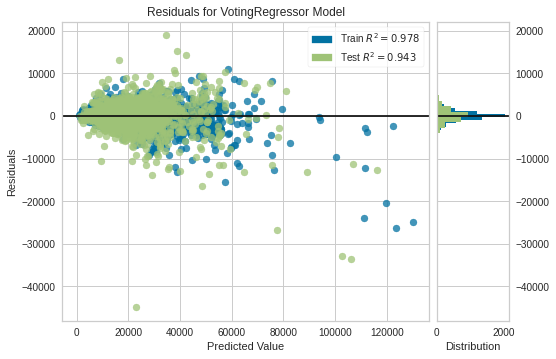

In [ ]:
# Train, Test data Residuals

plot_model(blender)

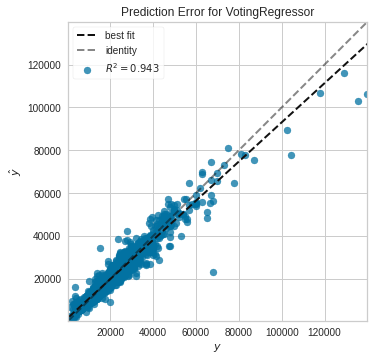

In [ ]:
# Prediction Error

plot_model(blender, plot='error')

## 전체 데이터 대상 Pycaret ( Catboost Only )

In [10]:
# csv data Integration

used_car_all = pd.DataFrame()

for dirname, _, filenames in os.walk('/content/drive/MyDrive/used_car'):
    for filename in filenames:
            each_car_all = pd.read_csv(os.path.join(dirname, filename), encoding='utf-8')
            each_car_all['company'] = filename.split('.')[0]
            used_car_all = pd.concat([used_car_all,each_car_all], axis=0)

In [11]:
used_car_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 64131 entries, 0 to 4859
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   model         64131 non-null  object 
 1   year          64131 non-null  int64  
 2   price         64131 non-null  int64  
 3   transmission  64131 non-null  object 
 4   mileage       64131 non-null  int64  
 5   fuelType      64131 non-null  object 
 6   tax           64131 non-null  int64  
 7   mpg           64131 non-null  float64
 8   engineSize    64131 non-null  float64
 9   company       64131 non-null  object 
dtypes: float64(2), int64(4), object(4)
memory usage: 5.4+ MB


In [ ]:
# DataFrame의 결측치, 이상치 제거 및 대체

used_car_all['model'] = used_car_all[['model']].apply(lambda x: x.str.strip())
used_car_all['engineSize'] = used_car_all[['engineSize']].replace(0,used_car_all['engineSize'].mode()[0])
used_car_all['tax'] = used_car_all[['tax']].replace(0,used_car_all[['tax']].median())

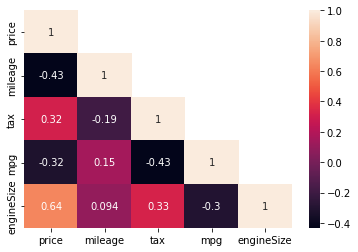

In [14]:
# 전체 데이터 대상 Heatmap

num_vars = ['price','mileage', 'tax', 'mpg', 'engineSize']
mask = np.triu(used_car_all[num_vars].corr(),1)
sns.heatmap(used_car_all[num_vars].corr(), mask=mask, annot=True)
plt.show()

In [ ]:
# 모델 분석환경 설정
# 결측치의 경우 Pycaret에서 자동처리 ( default : Numeric - mean, Categorical - constant )

model_all = setup(data=used_car_all, 
              target='price', 
              train_size=0.7,
              session_id=123,
              categorical_features = ['year'] # year 열은 연식으로 Categorical_feature로 강제 반영
              )

 
Setup Succesfully Completed.


,Description,Value
0,session_id,123
1,Transform Target,False
2,Transform Target Method,None
3,Original Data,"(64131, 10)"
4,Missing Values,False
5,Numeric Features,4
6,Categorical Features,5
7,Ordinal Features,False
8,High Cardinality Features,False
9,High Cardinality Method,None


In [ ]:
# Set-up을 바탕으로 각 모델별 성능비교(Hyper parameter defalut)

top_3_models_all = compare_models(sort='RMSE', n_select=1)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
0,CatBoost Regressor,1542.2078,6809789.7418,2593.7989,0.9396,0.1495,0.0930,1.9136
1,Random Forest,1585.7052,7804064.9989,2775.3761,0.9309,0.1412,0.0955,3.3338
2,Extra Trees Regressor,1543.3448,7927582.3423,2804.0303,0.9296,0.1300,0.0883,3.4572
3,Light Gradient Boosting Machine,1679.5184,8533886.2107,2908.0655,0.9244,0.1404,0.0984,0.1336
4,Decision Tree,2004.3607,12568809.8624,3529.5466,0.8889,0.1836,0.1202,0.1371
5,Gradient Boosting Regressor,2350.4010,12641351.4324,3547.7981,0.8881,0.1970,0.1511,2.7876
6,Extreme Gradient Boosting,2367.3685,12939401.1808,3590.0843,0.8855,0.1987,0.1523,1.4953
7,Bayesian Ridge,2391.8975,14010574.1564,3730.1773,0.8762,0.2730,0.1547,0.2333
8,Linear Regression,2389.7810,14015302.4771,3730.3749,0.8762,0.2738,0.1547,0.1173
9,Ridge Regression,2401.9592,14108477.0608,3744.8612,0.8754,0.2776,0.1553,0.0512


In [ ]:
cat_all = create_model('catboost', cross_validation = False)
tuned_cat_all = tune_model(cat_all, optimize = 'RMSE', n_iter = 100)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,1629.4185,8617778.5354,2935.6053,0.9127,0.1889,0.0985
1,1587.0307,6945656.0771,2635.4613,0.9357,0.1617,0.0914
2,1627.8511,6446558.7232,2539.0074,0.9448,0.1824,0.1011
3,1620.5992,10830458.5528,3290.9662,0.9077,0.1424,0.0924
4,1607.0850,5675800.5320,2382.3939,0.9534,0.1418,0.0981
5,1560.1146,5739690.8421,2395.7652,0.9490,0.1520,0.0981
6,1686.7178,7364953.1440,2713.8447,0.9363,0.1571,0.1038
7,1496.6351,5249104.8709,2291.0925,0.9508,0.1450,0.0954
8,1578.9663,7053605.1362,2655.8624,0.9405,0.1302,0.0938
9,1592.6047,6609483.6521,2570.8916,0.9436,0.1319,0.0928


In [ ]:
tuned_cat_all = tune_model(cat_all, optimize = 'RMSE', n_iter = 50)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,1414.8728,7366459.8813,2714.1223,0.9254,0.1544,0.0818
1,1434.0864,6467963.9416,2543.2192,0.9402,0.1259,0.0820
2,1445.5041,6448096.1021,2539.3102,0.9448,0.1339,0.0878
3,1483.1665,10045817.5558,3169.5138,0.9144,0.1327,0.0829
4,1368.6795,4806321.7518,2192.3325,0.9605,0.1329,0.0833
5,1397.3241,4985711.6558,2232.8707,0.9557,0.1325,0.0852
6,1576.4384,8980578.6923,2996.7614,0.9223,0.1607,0.1009
7,1342.2727,4488970.6107,2118.7191,0.9579,0.1294,0.0843
8,1391.5680,5711977.3762,2389.9743,0.9518,0.1464,0.0809
9,1465.0307,6489518.2935,2547.4533,0.9447,0.1217,0.0831


In [ ]:
tuned_cat_all.get_params()

{'border_count': 200,
 'depth': 7,
 'iterations': 500,
 'l2_leaf_reg': 3,
 'learning_rate': 0.3,
 'loss_function': 'RMSE',
 'random_state': 123,
 'silent': True}

In [ ]:
predict_model(tuned_cat_all)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,CatBoost Regressor,1408.5885,5.745553e+06,2396.9882,0.9525,0.1274,0.0826


,mileage,tax,mpg,engineSize,model_1 Series,model_180,model_2 Series,model_200,model_220,model_230,model_3 Series,model_4 Series,model_5 Series,model_6 Series,model_7 Series,model_8 Series,model_A Class,model_A1,model_A2,model_A3,model_A4,model_A5,model_A6,model_A7,model_A8,model_Accent,model_Amica,model_Auris,model_Avensis,model_Aygo,model_B Class,model_B-MAX,model_C Class,model_C-HR,model_C-MAX,model_CL Class,model_CLA Class,model_CLC Class,model_CLK,model_CLS Class,...,year_1999.0,year_2000.0,year_2001.0,year_2002.0,year_2003.0,year_2004.0,year_2005.0,year_2006.0,year_2007.0,year_2008.0,year_2009.0,year_2010.0,year_2011.0,year_2012.0,year_2013.0,year_2014.0,year_2015.0,year_2016.0,year_2017.0,year_2018.0,year_2019.0,year_2020.0,year_2060.0,transmission_Automatic,transmission_Manual,transmission_Other,transmission_Semi-Auto,fuelType_Diesel,fuelType_Electric,fuelType_Hybrid,fuelType_Other,fuelType_Petrol,company_audi,company_bmw,company_ford,company_hyundi,company_merc,company_toyota,price,Label
0,23000.0,20.0,72.4,1.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,13799.0,13573.3124
1,1000.0,145.0,57.7,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,37249.0,36351.1667
2,14847.0,260.0,35.8,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,22995.0,27163.6782
3,32236.0,150.0,68.9,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,6990.0,6960.5564
4,22999.0,145.0,52.3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,10300.0,10501.5471
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5767,3955.0,145.0,45.6,1.3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,20850.0,22667.7881
5768,13480.0,145.0,58.9,1.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,8698.0,8678.2166
5769,6307.0,145.0,64.2,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0